# Business Understanding
We hebben een dataset gekregen die bestaat uit strafbare feiten van de stad Denver van de afgelopen vijf jaar. De gegevens komen van het National Incident Based Reporting System (NIBRS). 

### User stories
- Als gemeente wil ik weten waar de meeste (top 5) verkeersincidenten plaatsvinden zodat er eventueel een aanpassing gemaakt kan worden in de infrastructuur.
    - Op een kaart weergeven waar het incident plaats vindt. 
    - Op de kaart het aantal incidenten weergeven. 
    - Als geen top 5 uitkomt geef dan de wijk aan waar de meeste verkeersincidenten plaatsvinden 
    


# Data Understanding

In [1]:
# importeer je packages
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

## Collect initial data
De data is aan ons aangeleverd in de vorm van twee .csv bestanden. Deze zijn met elkaar gekoppeld aan de hand van de identieke kolomnamen ‘offense_code’. Andere interessante gegevens zijn de datum en plaats waar en wanneer het strafbare feit is gepleegd. Met name de verkeersincidenten zijn in Denver erg hoog, we zullen specifiek voor de verkeersincidenten extra analyses doen.

In [2]:
df_crime = pd.read_csv('crime.csv', parse_dates=[
    'FIRST_OCCURRENCE_DATE',
    'LAST_OCCURRENCE_DATE',
    'REPORTED_DATE'
], dtype={
    'IS_CRIME': 'bool',
    'IS_TRAFFIC': 'bool'
})
df_offense_codes = pd.read_csv('offense_codes.csv')

## Describe data

In [3]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454540 entries, 0 to 454539
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   INCIDENT_ID             454540 non-null  int64         
 1   OFFENSE_ID              454540 non-null  int64         
 2   OFFENSE_CODE            454540 non-null  int64         
 3   OFFENSE_CODE_EXTENSION  454540 non-null  int64         
 4   OFFENSE_TYPE_ID         454540 non-null  object        
 5   OFFENSE_CATEGORY_ID     454540 non-null  object        
 6   FIRST_OCCURRENCE_DATE   454540 non-null  datetime64[ns]
 7   LAST_OCCURRENCE_DATE    152118 non-null  datetime64[ns]
 8   REPORTED_DATE           454540 non-null  datetime64[ns]
 9   INCIDENT_ADDRESS        414371 non-null  object        
 10  GEO_X                   450607 non-null  float64       
 11  GEO_Y                   450607 non-null  float64       
 12  GEO_LON                 450606

0. **INCIDENT_ID :** Bestaat uit een combinatie van INCIDENT_ID, OFFENSE_CODE en OFFENSE_CODE_EXTENSION. Dit zorgt ervoor dat iedere overtreding uniek identificeerbaar is.
1. **OFFENSE_ID:** Unieke integer voor iedere melding. Zo kan het bijvoorbeeld voorkomen dat er meerdere overtredingen worden gepleegd per melding
2. **OFFENSE_CODE:** De code waarmee verwezen wordt naar een algemene soort overtreding. In combinatie met
3. **OFFENSE_CODE_EXTENSION:** kan het specifieke misdrijf worden achterhaald.Een uitbreiding op OFFENSE_CODE. Geeft een specifiek misdrijf aan (ander CSV-bestand).
4. **OFFENSE_TYPE_ID:** Geeft de naam van het misdrijf weer. Bijvoorbeeld een aanrijding onder invloed, heroïnegebruik, etc.
5. **OFFENSE_CATEGORY_ID:** Geeft de basisnaam van het misdrijf weer. Een generalisatie van OFFENSE_TYPE_ID. Zo valt het gebruik van zowel heroïne als wiet onder het algemene misdrijf ‘drugsgebruik’.
6. **FIRST_OCCURRENCE_DATE:** De eerst mogelijk datum van het incident.
7. **LAST_OCCURRENCE_DATE:** als de FIRST_OCCURRENCE_DATE en de LAST_OCCURRENCE_DATE kolommen beide zijn ingevulgd dan is er een schatting gemaakt van het incident
8. **REPORTED_DATE:** datum waarop het delict werd gerapporteerd
9. **INCIDENT_ADDRESS:** de straat waar het incident heeft plaats gevonden. Deze kolom is niet altijd ingevuld in verband met privacy.
10. **GEO_X:** Geografische coördinaten
11. **GEO_Y:** GEO_Y
12. **GEO_LON:** lengtegraad
13. **GEO_LAT:** breedtegraad
14. **DISTRICT_ID:** Afgebakend geografisch gebied in Denver.
15. **PRECINCT_ID:** Het id van het gebied waar het incident is afgerond?
16. **NEIGHBORHOOD_ID:** buurt waarin het delict plaatsvond
17. **IS_CRIME:** Was het incident een misdaad?
18. **IS_TRAFFIC:** Was het incident een verkeersincident?

Wat ons opvalt aan kolommen waarin een datum hoort te staat dat ze van het type object zijn. Wij hebben bij het inporteren van het CSV-bestand dan ook het type aangepast naar een date. Daarnaast hebben wij de kolommen van IS_CRIME en IS_TRAFFIC aangepast naar een boolean.

In [28]:
df_crime.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
INCIDENT_ID,454540.0,4.207075e+09,1.457081e+10,2.019600e+04,2.016748e+09,2.018438e+09,2.020122e+09,2.020890e+12
OFFENSE_ID,454540.0,4.207075e+15,1.457081e+16,2.019652e+10,2.016748e+15,2.018438e+15,2.020122e+15,2.020890e+18
OFFENSE_CODE,454540.0,3.715744e+03,1.647371e+03,9.020000e+02,2.305000e+03,2.999000e+03,5.441000e+03,7.399000e+03
OFFENSE_CODE_EXTENSION,454540.0,2.070577e-01,5.784915e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
GEO_X,450607.0,3.165068e+06,7.114081e+05,1.000000e+00,3.138868e+06,3.145749e+06,3.163062e+06,4.067477e+07
GEO_Y,450607.0,1.695826e+06,2.323741e+05,1.000000e+00,1.683238e+06,1.694794e+06,1.701977e+06,1.046707e+08
GEO_LON,450606.0,-1.049235e+02,1.985000e+00,-1.154641e+02,-1.050062e+02,-1.049818e+02,-1.049203e+02,5.000000e-07
GEO_LAT,450606.0,3.971875e+01,7.516972e-01,0.000000e+00,3.970800e+01,3.973981e+01,3.975958e+01,3.990431e+01
DISTRICT_ID,454539.0,3.528043e+00,1.782229e+00,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
PRECINCT_ID,454539.0,3.703956e+02,1.790605e+02,1.110000e+02,2.210000e+02,3.230000e+02,5.210000e+02,7.590000e+02


Wat kunnen afleiden uit de volgende tabel:
- Er zijn **454545** incident meldingen geregisteerd.

In [8]:
print(df_crime.head());

   INCIDENT_ID         OFFENSE_ID  OFFENSE_CODE  OFFENSE_CODE_EXTENSION  \
0   2018869789   2018869789239900          2399                       0   
1    202111218    202111218570700          5707                       0   
2  20176005213  20176005213239901          2399                       1   
3  20196012240  20196012240230800          2308                       0   
4   2018861883   2018861883501600          5016                       0   

                  OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID FIRST_OCCURRENCE_DATE  \
0                     theft-other             larceny   2018-12-27 15:58:00   
1            criminal-trespassing    all-other-crimes   2021-01-06 21:20:00   
2                   theft-bicycle             larceny   2017-06-08 13:15:00   
3                 theft-from-bldg             larceny   2019-12-07 13:07:00   
4  violation-of-restraining-order    all-other-crimes   2018-12-22 20:15:00   

  LAST_OCCURRENCE_DATE       REPORTED_DATE     INCIDENT_ADDRESS      GEO_X

# Data Preparation
## Select Data
Om de job story (Als gemeente wil ik weten waar de meeste (top 5) verkeersincidenten plaatsvinden zodat er eventueel een aanpassing gemaakt kan worden in de infrastructuur.) uit te werken. Hebben wij de volgende kolommen nodig:
- INCIDENT_ID 
- OFFENSE_ID
- OFFENSE_TYPE_ID
- INCIDENT_ADDRESS
- NEIGHBORHOOD_ID

## Clean data


## Integrate Data


## Format Data


In [8]:
df_crime['year']=df_crime.REPORTED_DATE.apply(lambda x:x.strftime('%Y'))
df_crime['month']=df_crime.REPORTED_DATE.apply(lambda x:x.strftime('%m'))
df_crime['hour']=df_crime.REPORTED_DATE.apply(lambda x:x.strftime('%H'))
df_crime.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,year,month,hour
0,2018869789,2018869789239900,2399,0,theft-other,larceny,2018-12-27 15:58:00,NaT,2018-12-27 16:51:00,2681 N HANOVER CT,...,-104.866156,39.755561,5.0,512.0,stapleton,True,False,2018,12,16
1,202111218,202111218570700,5707,0,criminal-trespassing,all-other-crimes,2021-01-06 21:20:00,NaT,2021-01-07 00:23:00,1701 WYNKOOP ST,...,-104.999951,39.753054,6.0,612.0,union-station,True,False,2021,01,00
2,20176005213,20176005213239901,2399,1,theft-bicycle,larceny,2017-06-08 13:15:00,2017-06-08 17:15:00,2017-06-12 08:44:00,1705 17TH ST,...,-104.999264,39.753669,6.0,612.0,union-station,True,False,2017,06,08
3,20196012240,20196012240230800,2308,0,theft-from-bldg,larceny,2019-12-07 13:07:00,2019-12-07 18:30:00,2019-12-09 13:35:00,1350 N IRVING ST,...,-105.029208,39.738134,1.0,122.0,west-colfax,True,False,2019,12,13
4,2018861883,2018861883501600,5016,0,violation-of-restraining-order,all-other-crimes,2018-12-22 20:15:00,2018-12-22 20:31:00,2018-12-22 22:00:00,13625 E RANDOLPH PL,...,-104.828868,39.797750,5.0,521.0,montbello,True,False,2018,12,22


# Modeling

In [9]:
df_traffic=df_crime[df_crime.OFFENSE_CATEGORY_ID=='traffic-accident']
df_traffic.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,year,month,hour
12,2017455505,2017455505544100,5441,0,traffic-accident,traffic-accident,2017-07-10 18:00:00,NaT,2017-07-10 18:45:00,E EVANS AVE / S GRAPE ST,...,-104.925197,39.678463,3.0,323.0,goldsmith,False,True,2017,07,18
13,202110140,202110140540100,5401,0,traffic-accident-hit-and-run,traffic-accident,2021-01-06 10:28:00,NaT,2021-01-06 12:16:00,00 BLK N MAGNOLIA WAY,...,-104.911122,39.716867,3.0,321.0,lowry-field,False,True,2021,01,12
20,2016102596,2016102596544100,5441,0,traffic-accident,traffic-accident,2016-02-17 18:00:00,NaT,2016-02-17 18:00:00,4400 N RARITAN ST,...,-105.008741,39.776692,1.0,111.0,sunnyside,False,True,2016,02,18
24,2017612917,2017612917544100,5441,0,traffic-accident,traffic-accident,2017-09-12 14:55:00,NaT,2017-09-12 15:59:00,1601 N COLORADO BLVD,...,-104.940906,39.742085,2.0,213.0,city-park,False,True,2017,09,15
32,2017305192,2017305192540100,5401,0,traffic-accident-hit-and-run,traffic-accident,2017-05-10 18:06:00,NaT,2017-05-10 18:25:00,S WADSWORTH BLVD / W AMHERST AVE,...,-105.081457,39.665548,4.0,423.0,bear-valley,False,True,2017,05,18


Text(0, 0.5, 'aantal')

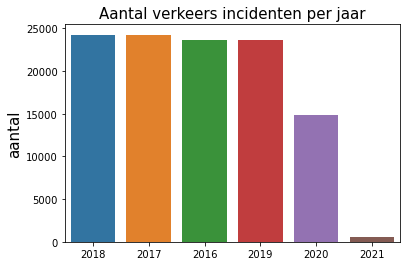

In [14]:
y=df_traffic.year.value_counts()
x=df_traffic.year.value_counts().index
sns.barplot(x=x,y=y)
plt.title("Aantal verkeers incidenten per jaar",size=15)
plt.ylabel('aantal',size=15)



Een reden voor de afname in verkeerincidenten kan zijn dat er door corona minder mensen de deur uitgingen in 2020, denk bijvoorbeeld aan thuis werken en lockdowns.

In [15]:
df_jobstory3 = pd.DataFrame(df_crime)
str_traffic = ['traffic-accident']
df_jobstory3 = df_jobstory3.loc[df_jobstory3['OFFENSE_CATEGORY_ID'].isin(str_traffic)]
df_filter_adress = df_jobstory3.groupby(['INCIDENT_ADDRESS'])['INCIDENT_ADDRESS'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df_filter_adress.head(10)

,INCIDENT_ADDRESS,count
19028,I25 HWYNB / W 6TH AVE,769
19198,I70 HWYEB / N HAVANA ST,456
19207,I70 HWYEB / N PEORIA ST,371
19034,I25 HWYNB / W ALAMEDA AVE,371
18952,I25 HWYNB / 20TH ST,350
19057,I25 HWYSB / 20TH ST,349
24600,W 6TH AVE / N FEDERAL BLVD,318
18968,I25 HWYNB / E HAMPDEN AVE,316
19022,I25 HWYNB / W 23RD AVE,312
19037,I25 HWYNB / W COLFAX AVE,278


# Evaluation

- Een reden voor de afname in verkeerincidenten kan zijn dat er door corona minder mensen de deur uit gaan, denk bijvoorbeeld aan thuis werken en lockdowns.